In [3]:
import numpy as np
import cv2
import os
import tensorflow as tf
import keras
from keras import layers, models
from sklearn.model_selection import train_test_split
from keras.preprocessing import image

from DataScience.Week14 import X_train

In [4]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

In [6]:
img_height, img_width = 48, 48

def load_dataset(train_dir, test_dir):
    def load_images(directory):
        images = []
        labels = []
        expressions = ['angry', 'fear', 'happy', 'sadness', 'surprise', 'neutral']
        for label,expression in enumerate(expressions):
            expression_folder = os.path.join(directory, expression)
            if not os.path.exists(expression_folder):
                continue
            for filename in os.listdir(expression_folder):
                img_path = os.path.join(expression_folder, filename)
                img = cv2.imread(img_path)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

                if len(faces) == 0:
                    continue

                x,y,w,h = faces[0]

                face_img = img[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (img_height, img_width))
                face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2GRAY)
                face_img = np.expand_dims(face_img, axis=-1)

                images.append(face_img)
                labels.append(label)
        images = np.array(images, dtype="float32")
        labels = np.array(labels)
        return images, labels
    X_train, Y_train = load_images(train_dir)
    X_test, Y_test = load_images(test_dir)

    return X_train, X_test, Y_train, Y_test

In [7]:
train_dir = 'data/CK_dataset/train'
test_dir = 'data/CK_dataset/test'

X_train, X_test, Y_train, Y_test = load_dataset(train_dir, test_dir)

print("Training data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Training data shape:  (300, 48, 48, 1)
Test data shape:  (124, 48, 48, 1)


In [10]:
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')
])

In [13]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

loss, accuracy = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

model.save('data/model/face_expression_model.keras')

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - accuracy: 0.9304 - loss: 0.2009 - val_accuracy: 0.5887 - val_loss: 1.6200
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9214 - loss: 0.2268 - val_accuracy: 0.6129 - val_loss: 1.8880
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9154 - loss: 0.2279 - val_accuracy: 0.6290 - val_loss: 1.7370
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9559 - loss: 0.1996 - val_accuracy: 0.5968 - val_loss: 1.5955
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9613 - loss: 0.1422 - val_accuracy: 0.6532 - val_loss: 1.9179
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9440 - loss: 0.1243 - val_accuracy: 0.6048 - val_loss: 1.7132
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9551 - loss: 0.0951 - val_accuracy: 0.6452 - val_loss: 2.0169
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9547 - loss: 0.1340 - val_accuracy: 0.5968 - 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


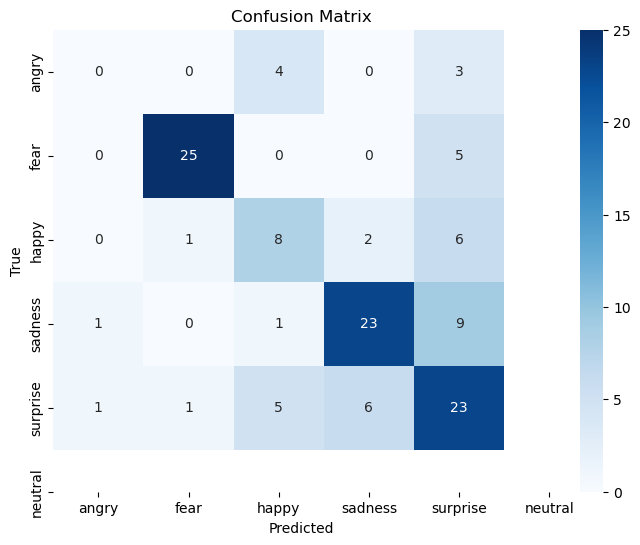

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,6))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['angry', 'fear', 'happy', 'sadness', 'surprise', 'neutral'], yticklabels=['angry', 'fear', 'happy', 'sadness', 'surprise', 'neutral'])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


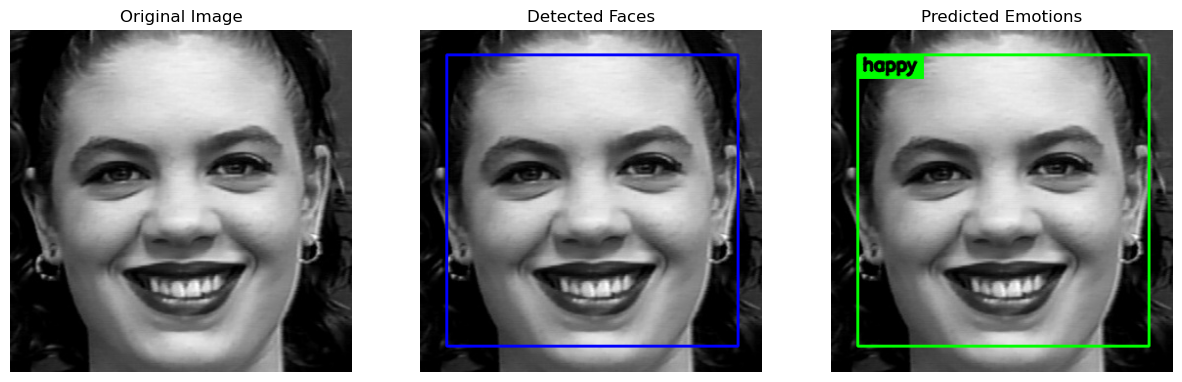

In [17]:
import numpy as np
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

model = keras.models.load_model('data/model/face_expression_model.keras')

img_height, img_width = 48, 48

expressions = ['angry', 'fear', 'happy', 'sadness', 'surprise', 'neutral']

face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

def preprocess_face(face):
    face_resized = cv2.resize(face, (img_height, img_width))
    face_resized = np.expand_dims(face_resized, axis=-1)
    face_resized = np.expand_dims(face_resized, axis=0)
    face_resized = face_resized.astype("float32")
    return face_resized

img_path = 'data/FER-testingimages/0.jpg'

original_img = cv2.imread(img_path)
gray_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)

face_detected_img = original_img.copy()
final_img = original_img.copy()

for (x, y, w, h) in faces:
    face = gray_img[y:y+h, x:x+w]
    processed_face = preprocess_face(face)

    prediction = model.predict(processed_face)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_emotion = expressions[predicted_class[0]]

    cv2.rectangle(face_detected_img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    cv2.rectangle(final_img, (x, y), (x + w, y + h), (0,255,0), 2)

    label_bg_color = (0, 255,0)
    text_color = (0,0,0)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    font_thickness = 2

    (text_width, text_height), _ = cv2.getTextSize(predicted_emotion, font, font_scale, font_thickness)
    label_x1, label_y1 = x,y
    label_x2, label_y2 = x + text_width + 10, y + text_height + 10

    cv2.rectangle(final_img, (label_x1, label_y1), (label_x2, label_y2), label_bg_color, -1)

    cv2.putText(final_img, predicted_emotion, (x+5, y+text_height+2), font, font_scale, text_color, font_thickness, cv2.LINE_AA)

original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
face_detected_img_rgb = cv2.cvtColor(face_detected_img, cv2.COLOR_BGR2RGB)
final_img_rgb = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(original_img_rgb)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(face_detected_img_rgb)
axes[1].set_title("Detected Faces")
axes[1].axis('off')

axes[2].imshow(final_img_rgb)
axes[2].set_title("Predicted Emotions")
axes[2].axis('off')

plt.show()